In [7]:
import zipfile
import pandas as pd
import re
import demoji
import nltk
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import pandas as pd

nltk.download('punkt_tab') #tokenizzazione
nltk.download('stopwords') # stop words
nltk.download('wordnet') # lemmatizzazione
demoji.download_codes() # dizionario delle emoji

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sarab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sarab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\sarab\AppData\Local\Temp\ipykernel_28364\2824634240.py:15: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() # dizionario delle emoji


In [8]:
zip_path = 'redditComments.zip'

with zipfile.ZipFile(zip_path) as z:
    with z.open('ruddit_comments_score.csv') as csv:
        df = pd.read_csv(csv)

print("Dataset shape:", df.shape)

Dataset shape: (5966, 3)


In [9]:
df = df.drop(columns=['comment_id','score'])
print(df.columns)

Index(['body'], dtype='object')


In [10]:
sexual_words = [
    "sex", "porn", "xxx", "nude", "explicit", "18+", "nsfw", "hardcore",
    "naked", "erotic", "fetish", "fuck", "bitch", "boobs",
    "dick", "pussy", "cock", "slut", "milf", "cum", "orgasm",
    "blowjob", "handjob", "deepthroat", "threesome", "gangbang",
    "stripper", "hooker", "escort", "camgirl", "sugar daddy",
    "bondage", "bdsm", "dominatrix", "kinky", "lick", "moan",
    "anal", "vibrator", "masturbation", "climax", "sex tape",
    "playboy", "sensual", "seduce", "twerking", "squirting",
    "penetration", "foreplay", "erogenous", "nipple", "lap dance",
    "thong", "lingerie", "panties", "semen", "horny", "aroused",
    "provocative", "breasts", "vagina", "penis", "buttocks",
    "oral sex", "oral action", "attractive", "seduction",
    "softcore", "hardcore", "deepfake", "taboo", "cunnilingus",
    "dominance", "submission", "degrading", "wet dream",
    "nude selfies", "sugar baby", "sexual fantasy",
]

violence_words = [
    "murder", "kill", "slaughter", "torture", "execute", "decapitate",
    "terrorist", "bomb", "massacre", "shoot", "gun", "rifle",
    "stabbing", "lynch", "assassinate", "bloodbath", "beheading",
    "strangle", "rape", "abuse", "assault", "harassment",
    "pedophile", "molestation", "kidnap", "hostage", "extortion",
    "death threat", "violence", "riot", "fight", "attack",
    "mugging", "aggression", "choke", "punch", "stab", "burn",
    "hang", "drown", "brutal", "mutilation", "genocide",
    "suffocate", "savage", "blood", "gore", "brutality",
    "war crime", "child abuse", "animal abuse", "executed",
    "tied up", "psychopath", "serial killer", "homicide",
    "strangulation", "cruel", "sadistic", "deadly", "hatred",
    "threat", "beaten", "burned alive", "gunned down",
    "assaulted", "violated", "warzone", "dismember",
    "disfigure", "tortured", "violent", "corpses"
]


In [11]:
#Rimozione dei commenti nulli
df = df.dropna(subset=['body'])
df.drop(df[df['body'].str.startswith('[')].index, inplace=True)

words_to_count = violence_words + sexual_words
comment_count = df["body"].astype(str).apply(lambda comment: any(re.search(rf"\b{re.escape(word)}\b", comment, re.IGNORECASE) for word in words_to_count)).sum()
print(f"Numero di commenti contenenti almeno una parola della lista: {comment_count}")

Numero di commenti contenenti almeno una parola della lista: 1054


In [12]:
dict1 = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "won't": "will not", "can't": "cannot", "i'm": "i am", "you're": "you are",
    "it's": "it is", "they're": "they are", "we're": "we are", "isn't": "is not",
    "aren't": "are not", "haven't": "have not", "hasn't": "has not",
    "wasn't": "was not", "weren't": "were not", "shouldn't": "should not",
    "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not"
}

dict2 = {
    "nude": "naked", "xxx": "porn", "tits": "breasts", "dick": "penis",
    "pussy": "vagina", "bj": "blowjob", "cum": "semen", "hornyk": "aroused",
    "milf": "attractive older woman", "nsfw": "not safe for work",
    "thirsty": "sexually desperate", "ass": "buttocks", "booty": "buttocks",
    "deepthroat": "oral sex", "suck": "oral action", "sexy": "attractive"
}

def expand_contractions_and_slang(text):
    #applicazione dei dizionari
    for key, value in {**dict1, **dict2}.items():
        text = re.sub(r"\b" + key + r"\b", value, text)
    return text

def correct_spelling(text):
    #correzione degli errori ortografici
    return str(TextBlob(text).correct())

def segment_sentences(text):
    # divisione in frasi
    return sent_tokenize(text) if isinstance(text, str) else []

def replace_emojis_and_ascii(text):
    text = demoji.replace_with_desc(text)

    # rimozione elementi non validi
    text = re.sub(r'(\*\*|\*\w+\*|\W+\*{2,})', '', text)
    text = re.sub(r'(\bxx+\b)', 'explicit', text) 
    return text

important_stopwords = {"not", "no", "nor", "n't", "never", "hardly", "barely", "scarcely",
                       "very", "really", "so", "extremely", "super", "terribly", "horribly",
                       "awfully", "slightly", "somewhat", "but", "however", "although",
                       "though", "yet", "i", "we", "you", "he", "she", "they", "my", "your",
                       "why", "how", "what"}

stop_words = set(stopwords.words("english")) - important_stopwords


def preprocess_text(text):
    """Esegue il preprocessing completo di un testo per adult content filtering."""
    if isinstance(text, str):
        text = text.lower()
        text = expand_contractions_and_slang(text)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"@\w+|#\w+", "", text)
        text = replace_emojis_and_ascii(text)
        text = re.sub(r"[^a-z\s]", "", text)
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = correct_spelling(" ".join(tokens))

        return text
    return ""
df['Segmented_Comments'] = df['body'].apply(segment_sentences)
df['Processed_Comment'] = df['body'].apply(preprocess_text)

df.head()

,body,Segmented_Comments,Processed_Comment
0,> The difference in average earnings between m...,[> The difference in average earnings between ...,difference average earnings men woman explaine...
1,"The myth is that the ""gap"" is entirely based o...","[The myth is that the ""gap"" is entirely based ...",myth gap entirely based sex person
3,The assertion is that women get paid less for ...,[The assertion is that women get paid less for...,assertion woman get paid less job they get pai...
4,You said in the OP that's not what they're mea...,[You said in the OP that's not what they're me...,you said op that not what they measuring they ...
5,>Men and women are not payed less for the same...,[>Men and women are not payed less for the sam...,men woman not played less job i not think many...


In [ ]:
df.to_pickle("Preprocessed_RedditComment_ACF.pkl")

In [ ]:
path_pickle = "Preprocessed_RedditComment_ACF.pkl"

df = pd.read_pickle(path_pickle)
df.head()
df.info()

In [13]:
words_to_count = sexual_words + violence_words

def classify_comment(comment):
    if any(re.search(rf"\b{re.escape(word)}\b", str(comment), re.IGNORECASE) for word in words_to_count):
        return 1  # Commenti classificati per adulti
    else:
        return 0  # Commenti senza restrizioni

df['Content_Label'] = df['Processed_Comment'].apply(classify_comment)

print(df['Content_Label'].value_counts())
df.info()

Content_Label
0    4608
1    1114
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 5722 entries, 0 to 5965
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   body                5722 non-null   object
 1   Segmented_Comments  5722 non-null   object
 2   Processed_Comment   5722 non-null   object
 3   Content_Label       5722 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 223.5+ KB


In [14]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

class_counts = df['Content_Label'].value_counts()
total_adult = class_counts[1]
total_safe = class_counts[0] 
target_safe = int(total_adult * (60 / 40))

if total_safe > target_safe:
    undersampler = RandomUnderSampler(sampling_strategy={0: target_safe}, random_state=42)
    x_balanced, y_balanced = undersampler.fit_resample(df, df['Content_Label'])

    print("\n🔹 Distribuzione delle classi:\n", pd.Series(y_balanced).value_counts())

    df_balanced = pd.DataFrame(x_balanced)
else:
    df_balanced = df  # Se già bilanciato, usa il dataset originale


🔹 Distribuzione delle classi:
 Content_Label
0    1671
1    1114
Name: count, dtype: int64


C:\Users\sarab\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔹 Using device: cpu
🔹 Distribuzione delle classi dopo il bilanciamento:
 Content_Label
0    1671
1    1114
Name: count, dtype: int64


C:\Users\sarab\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 140/140 [06:48<00:00,  2.92s/it, acc=0.46, loss=0.676] 



🔹 Epoch 1: Training Loss: 0.7166, Training Accuracy: 0.4601
🔹 Validation Loss: 0.6862, Validation Accuracy: 0.6050


Epoch 2: 100%|██████████| 140/140 [06:33<00:00,  2.81s/it, acc=0.54, loss=0.817] 



🔹 Epoch 2: Training Loss: 0.6876, Training Accuracy: 0.5404
🔹 Validation Loss: 0.6286, Validation Accuracy: 0.7199


Epoch 3: 100%|██████████| 140/140 [06:12<00:00,  2.66s/it, acc=0.657, loss=0.681]



🔹 Epoch 3: Training Loss: 0.6272, Training Accuracy: 0.6571
🔹 Validation Loss: 0.4866, Validation Accuracy: 0.7864


Epoch 4: 100%|██████████| 140/140 [07:16<00:00,  3.12s/it, acc=0.751, loss=0.426]



🔹 Epoch 4: Training Loss: 0.5222, Training Accuracy: 0.7509
🔹 Validation Loss: 0.3695, Validation Accuracy: 0.8564


Epoch 5: 100%|██████████| 140/140 [07:16<00:00,  3.12s/it, acc=0.861, loss=0.862]



🔹 Epoch 5: Training Loss: 0.3640, Training Accuracy: 0.8609
🔹 Validation Loss: 0.3455, Validation Accuracy: 0.8438


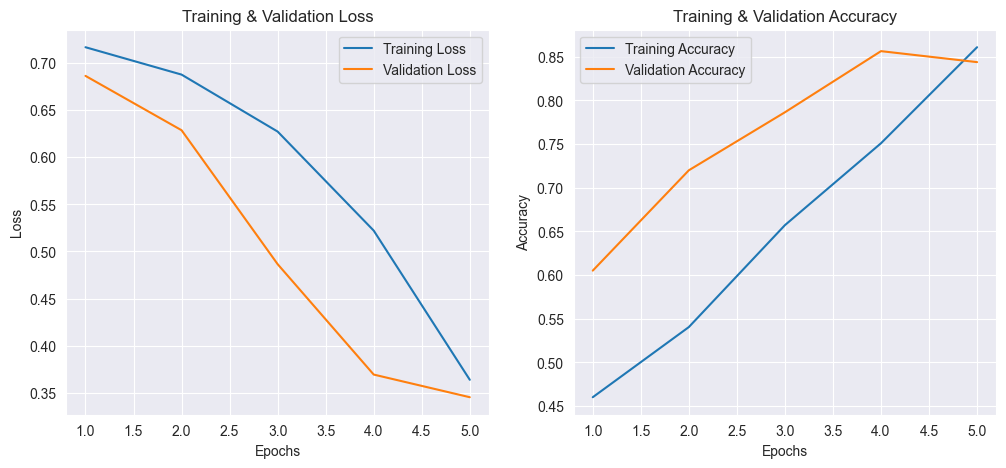

   Epoch  Training Loss  Training Accuracy  Validation Loss  \
0      1         0.7166             0.4601           0.6862   
1      2         0.6876             0.5404           0.6286   
2      3         0.6272             0.6571           0.4866   
3      4         0.5222             0.7509           0.3695   
4      5         0.3640             0.8609           0.3455   

   Validation Accuracy  
0               0.6050  
1               0.7199  
2               0.7864  
3               0.8564  
4               0.8438  


In [15]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🔹 Using device: {device}")

print("🔹 Distribuzione delle classi dopo il bilanciamento:\n", df_balanced['Content_Label'].value_counts())

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced['Processed_Comment'].tolist(), df_balanced['Content_Label'].tolist(),
    test_size=0.2, stratify=df_balanced['Content_Label'], random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')

class ContentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ContentDataset(train_encodings, train_labels)
test_dataset = ContentDataset(test_encodings, test_labels)

config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # 🔹 Classificazione binaria
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class_counts = df_balanced['Content_Label'].value_counts().sort_index()
total_samples = len(df_balanced)
class_weights = {i: total_samples / class_counts[i] for i in class_counts.index}
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)

def train_model(model, train_loader, val_loader, epochs=5):

    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    results = []
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss, correct, total = 0, 0, 0

        for batch in loop:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item(), acc=correct / total)

        train_accuracy = correct / total
        avg_training_loss = total_loss / len(train_loader)

        val_loss, val_accuracy = evaluate_model(model, val_loader)

        train_losses.append(avg_training_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"\n🔹 Epoch {epoch + 1}: Training Loss: {avg_training_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"🔹 Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        results.append({
            "Epoch": epoch + 1,
            "Training Loss": round(avg_training_loss, 4),
            "Training Accuracy": round(train_accuracy, 4),
            "Validation Loss": round(val_loss, 4),
            "Validation Accuracy": round(val_accuracy, 4)
        })

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

def evaluate_model(model, val_loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(val_loader), correct / total


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

results_df = train_model(model, train_loader, val_loader, epochs=5)

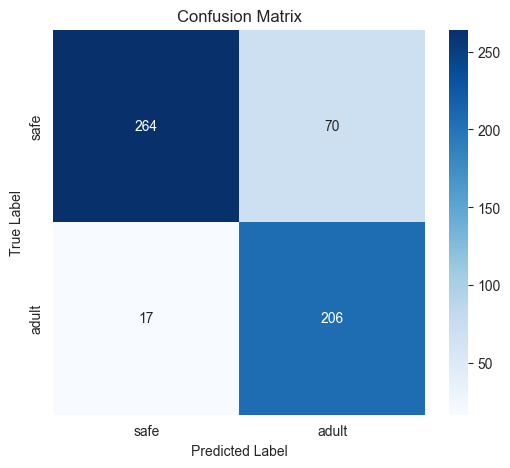


🔹 Classification Report:
              precision    recall  f1-score   support

        safe       0.94      0.79      0.86       334
       adult       0.75      0.92      0.83       223

    accuracy                           0.84       557
   macro avg       0.84      0.86      0.84       557
weighted avg       0.86      0.84      0.85       557



In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, val_loader, class_names=['safe', 'adult']):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].cpu().numpy()

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n🔹 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

plot_confusion_matrix(model, val_loader)